In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import m2cgen as m2c
import joblib
import pickle
import glob
import sys


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

print("done")



done


# Preprocessing



In [2]:
# Import data to use as training data

dataframes_in = []
dataframes_out = []
files = glob.glob("clean_csv/*.csv")
print(files)
for filename in files:
    if "in_" in filename:
        dataframes_in.append(pd.read_csv(filename))
    else:
        dataframes_out.append(pd.read_csv(filename))

in_data = pd.concat(dataframes_in)
out_data = pd.concat(dataframes_out)

print(in_data.head())

print(out_data.head())

['clean_csv\\in_240505_1409.csv', 'clean_csv\\in_240505_1426.csv', 'clean_csv\\in_240505_1432.csv', 'clean_csv\\out_240504_0821.csv', 'clean_csv\\out_240504_1132.csv', 'clean_csv\\out_240504_1219.csv', 'clean_csv\\out_240504_1745.csv', 'clean_csv\\out_240505_1424.csv']
    timestamp   uv  light  accelX  accelY  accelZ     r     g     b     c  \
0  1712470664  352     55    -875    2543    8172  2885  2916  2127  8011   
1  1712470666  360     63    1878    5915    5502  3012  3072  2246  8512   
2  1712470668  368     57    2491    5266    5554  3154  3234  2354  8931   
3  1712470670  372     84    2132    3673    5891  3404  3486  2535  9623   
4  1712470672  385     63    -195      89    7006  3033  3282  2481  9054   

   colorTemp   lux  class  code  
0       4199  2109    NaN   NaN  
1       4232  2227    NaN   NaN  
2       4234  2357    NaN   NaN  
3       4228  2541    NaN   NaN  
4       4507  2379    NaN   NaN  
    timestamp  uv  light  accelX  accelY  accelZ      r      g 

In [3]:
in_data["class"] = 0
out_data["class"] = 1

all_data = pd.concat([in_data, out_data])

In [4]:
all_data.head()

,timestamp,uv,light,accelX,accelY,accelZ,r,g,b,c,colorTemp,lux,class,code
0,1712470664,352,55,-875,2543,8172,2885,2916,2127,8011,4199,2109,0,NaN
1,1712470666,360,63,1878,5915,5502,3012,3072,2246,8512,4232,2227,0,NaN
2,1712470668,368,57,2491,5266,5554,3154,3234,2354,8931,4234,2357,0,NaN
3,1712470670,372,84,2132,3673,5891,3404,3486,2535,9623,4228,2541,0,NaN
4,1712470672,385,63,-195,89,7006,3033,3282,2481,9054,4507,2379,0,NaN


# Data Imbalance Check
There are 166 indoor and 14 outdoor samples in the dataset. The data is not balanced.

In [5]:
print(all_data["class"].value_counts())

X = all_data.drop(['timestamp', 'class', 'code', 'uv'], axis=1)

y = all_data['class']



class
0    1234
1     869
Name: count, dtype: int64


# Create new features

In [6]:
# accelerometer

all_data['accelN'] = all_data.apply(lambda row: (row.accelX + row.accelY + row.accelZ) / 3, axis=1)
all_data['accelMagnitude'] = all_data.apply(lambda row: row.accelX ** 2 + row.accelY ** 2 + row.accelZ ** 2, axis=1)
all_data['accelXY'] = all_data.apply(lambda row: (row.accelX * row.accelY) ** 2, axis=1)

import math
# light
all_data['redVSgreen'] = all_data.apply(lambda row: row.r / row.g, axis=1)
all_data['redVSgreen'] = all_data.apply(lambda row: row.b / row.r, axis=1)
all_data['redVSgreen'] = all_data.apply(lambda row: row.b / row.g, axis=1)
all_data['redVSgreen'] = all_data.apply(lambda row: math.log(row.r) / math.log(row.g), axis=1)
all_data['redVSgreen'] = all_data.apply(lambda row: math.log(row.b) / math.log(row.r), axis=1)
all_data['redVSgreen'] = all_data.apply(lambda row: math.log(row.b) / math.log(row.g), axis=1)



x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 512)


# Useful functions and values for final evaluation

In [7]:
#initializing useful lists
accuracies = {"Test": {}, "Train": {}}
precisions = {"Test": {}, "Train": {}}
recall = {"Test": {}, "Train": {}}
f_score = {"Test": {}, "Train": {}}

def set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name):
    test_precision, test_recall, test_f_score, _ = precision_recall_fscore_support(y_test, test_predictions)
    train_precision, train_recall, train_f_score, _ = precision_recall_fscore_support(y_train, train_predictions)


    print(name, 1 - test_precision, 1 - test_recall, 1 - test_f_score)
    print(name, 1 - train_precision, 1 - train_recall, 1 - train_f_score)

    precisions["Test"][name] = test_precision
    precisions["Train"][name] = train_precision

    recall["Test"][name] = test_recall
    recall["Train"][name] = train_recall

    f_score["Test"][name] = test_f_score
    f_score["Train"][name] = train_f_score

def set_accuracies(name, train_accuracy, test_accuracy):
    accuracies["Train"][name] = train_accuracy
    accuracies["Test"][name] = test_accuracy


# Classifiers

Decision Tree [0.01351351 0.03043478] [0.02341137 0.01762115] [0.01848739 0.02407002]
Decision Tree [0. 0.] [0. 0.] [0. 0.]


[Text(0.673469387755102, 0.9583333333333334, 'b <= 4204.0\ngini = 0.483\nsamples = 1577\nvalue = [935, 642]'),
 Text(0.4557823129251701, 0.875, 'c <= 826.0\ngini = 0.259\nsamples = 1100\nvalue = [932, 168]'),
 Text(0.2925170068027211, 0.7916666666666666, 'accelZ <= 3856.5\ngini = 0.064\nsamples = 152\nvalue = [5, 147]'),
 Text(0.23809523809523808, 0.7083333333333334, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.3469387755102041, 0.7083333333333334, 'light <= 53.0\ngini = 0.013\nsamples = 148\nvalue = [1, 147]'),
 Text(0.2925170068027211, 0.625, 'gini = 0.0\nsamples = 147\nvalue = [0, 147]'),
 Text(0.4013605442176871, 0.625, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6190476190476191, 0.7916666666666666, 'colorTemp <= 6488.0\ngini = 0.043\nsamples = 948\nvalue = [927, 21]'),
 Text(0.564625850340136, 0.7083333333333334, 'accelY <= -6841.5\ngini = 0.025\nsamples = 939\nvalue = [927, 12]'),
 Text(0.5102040816326531, 0.625, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0

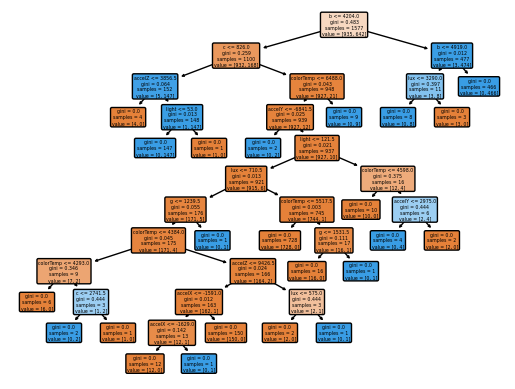

In [8]:
dTree = DecisionTreeClassifier(random_state = 512)

dTree.fit(x_train, y_train)

test_score = dTree.score(x_test, y_test)
train_score = dTree.score(x_train, y_train)
# print(f"A Decision Tree classifier running on the breast cancer dataset from sklearn gives a probility of{test_score * 100: .3f}% on the training data and a probability of{train_score * 100: .3f}%.")

test_predictions = dTree.predict(x_test)
train_predictions = dTree.predict(x_train)

name = "Decision Tree"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)


# plt.figure(figsize=(15, 7.5))
plot_tree(dTree, filled=True, rounded = True, feature_names=X.columns.tolist())



In [21]:
import sys
!{sys.executable} -m pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [22]:

from xgboost import XGBClassifier, plot_importance



xgbClassifier = XGBClassifier(random_state = 42)
fit = xgbClassifier.fit(x_train.to_numpy(), y_train.to_numpy()) # looking up in xgboost docs, it can't be a pandas dataframe, but can be a numpy array.
xgbClassifier.base_score = 0
test_score = xgbClassifier.score(x_test, y_test)
train_score = xgbClassifier.score(x_train, y_train)




test_predictions = xgbClassifier.predict(x_test)
train_predictions = xgbClassifier.predict(x_train)


name = "XGBoost"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)

plot_importance(fit,  importance_type = 'gain')



ModuleNotFoundError: No module named 'xgboost'

In [9]:
bagging = BaggingClassifier(random_state = 512)
bagging.fit(x_train, y_train)

test_score = bagging.score(x_test, y_test)
train_score = bagging.score(x_train, y_train)




test_predictions = bagging.predict(x_test)
train_predictions = bagging.predict(x_train)

name = "Bagging"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)

Bagging [0.0166113  0.01333333] [0.01003344 0.02202643] [0.01333333 0.01769912]
Bagging [0.00106838 0.        ] [0.         0.00155763] [0.00053447 0.00077942]


In [10]:
adaboost = AdaBoostClassifier(random_state=512)
adaboost.fit(x_train, y_train)

test_score = adaboost.score(x_test, y_test)
train_score = adaboost.score(x_train, y_train)

test_predictions = adaboost.predict(x_test)
train_predictions = adaboost.predict(x_train)

name = "Adaboost"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)


Adaboost [0.01333333 0.01327434] [0.01003344 0.01762115] [0.01168614 0.01545254]
Adaboost [0. 0.] [0. 0.] [0. 0.]


In [11]:
random_forest = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 51)
random_forest.fit(x_train, y_train)

test_score = random_forest.score(x_test, y_test)
train_score = random_forest.score(x_train, y_train)






test_predictions = random_forest.predict(x_test)
train_predictions = random_forest.predict(x_train)

name = "Random Forest"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)

Random Forest [0.01328904 0.00888889] [0.00668896 0.01762115] [0.01       0.01327434]
Random Forest [0.00106838 0.        ] [0.         0.00155763] [0.00053447 0.00077942]


In [12]:
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)

test_score = naive_bayes.score(x_test, y_test)
train_score = naive_bayes.score(x_train, y_train)






test_predictions = naive_bayes.predict(x_test)
train_predictions = naive_bayes.predict(x_train)

name = "Naive Bayes"
set_accuracies(name, train_score, test_score)
set_precisions_recall_f_score(y_test, test_predictions, y_train, train_predictions, name)

Naive Bayes [0.14825581 0.03296703] [0.02006689 0.2246696 ] [0.08864697 0.1393643 ]
Naive Bayes [0.14661654 0.05263158] [0.02887701 0.24299065] [0.09154577 0.15844156]


# Benchmarks
Comparing tables that compare the Accuracy, Precision and Recall of the different models.

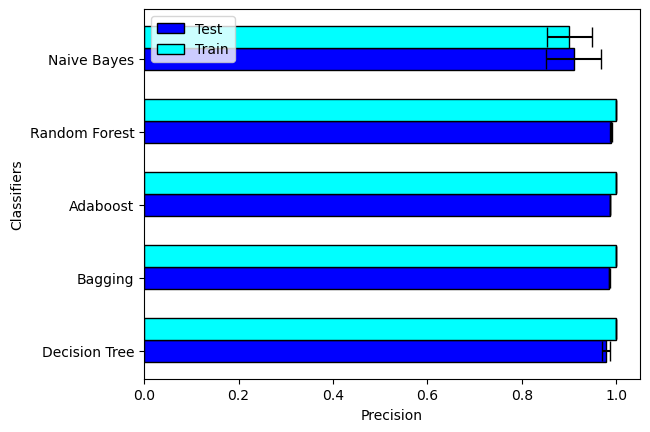

{'Test': {'Decision Tree': array([0.98648649, 0.96956522]), 'Bagging': array([0.9833887 , 0.98666667]), 'Adaboost': array([0.98666667, 0.98672566]), 'Random Forest': array([0.98671096, 0.99111111]), 'Naive Bayes': array([0.85174419, 0.96703297])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99893162, 1.        ]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99893162, 1.        ]), 'Naive Bayes': array([0.85338346, 0.94736842])}}


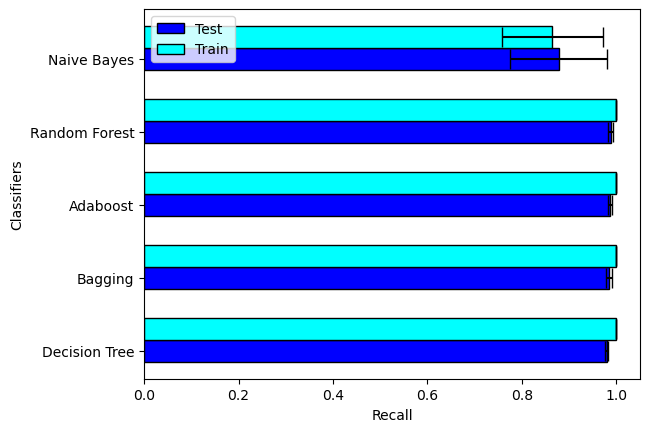

{'Test': {'Decision Tree': array([0.97658863, 0.98237885]), 'Bagging': array([0.98996656, 0.97797357]), 'Adaboost': array([0.98996656, 0.98237885]), 'Random Forest': array([0.99331104, 0.98237885]), 'Naive Bayes': array([0.97993311, 0.7753304 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([1.        , 0.99844237]), 'Adaboost': array([1., 1.]), 'Random Forest': array([1.        , 0.99844237]), 'Naive Bayes': array([0.97112299, 0.75700935])}}


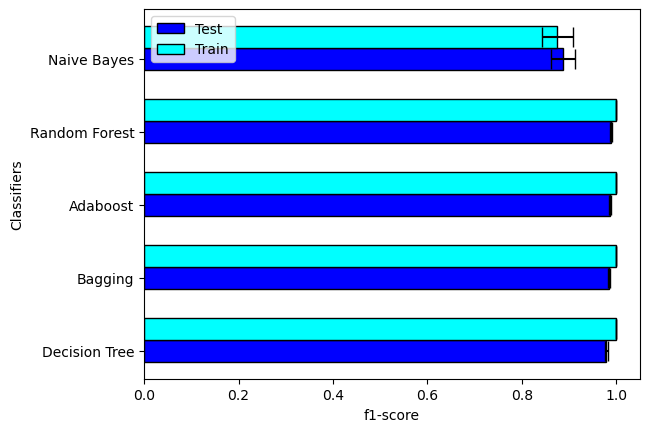

{'Test': {'Decision Tree': array([0.98151261, 0.97592998]), 'Bagging': array([0.98666667, 0.98230088]), 'Adaboost': array([0.98831386, 0.98454746]), 'Random Forest': array([0.99      , 0.98672566]), 'Naive Bayes': array([0.91135303, 0.8606357 ])}, 'Train': {'Decision Tree': array([1., 1.]), 'Bagging': array([0.99946553, 0.99922058]), 'Adaboost': array([1., 1.]), 'Random Forest': array([0.99946553, 0.99922058]), 'Naive Bayes': array([0.90845423, 0.84155844])}}


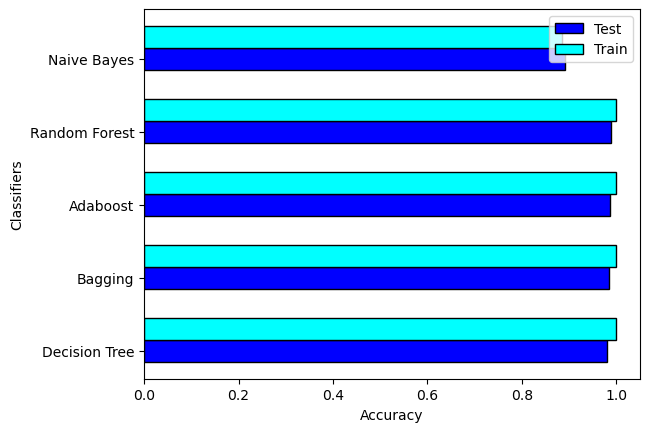

{'Test': {'Decision Tree': 0.9790874524714829, 'Bagging': 0.9847908745247148, 'Adaboost': 0.9866920152091255, 'Random Forest': 0.9885931558935361, 'Naive Bayes': 0.8916349809885932}, 'Train': {'Decision Tree': 1.0, 'Bagging': 0.9993658845909955, 'Adaboost': 1.0, 'Random Forest': 0.9993658845909955, 'Naive Bayes': 0.8839568801521877}}


In [13]:
def draw_table_w_conf_int(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())
    test_exp = []
    test_err = []
    for test_result in test_results:
        test_exp.append(test_result[0] + (test_result[1] - test_result[0]) / 2)
        test_err.append(abs(test_result[1] - test_result[0]) / 2)

    train_exp = []
    train_err = []
    for train_result in train_results:
        train_exp.append(train_result[0] + (train_result[1] - train_result[0]) / 2)
        train_err.append(abs(train_result[1] - train_result[0]) / 2)
    
    r1 = np.arange(len(test_exp))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_exp, height = bar_width, color = 'blue', edgecolor = 'black', xerr=test_err, capsize=7, label="Test")

    plt.barh(r2, train_exp, height = bar_width, color = 'cyan', edgecolor = 'black', xerr=train_err, capsize=7, label='Train')

    plt.yticks([r for r in range(len(test_exp))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()


def draw_table(data, statistic):
    bar_width = 0.3

    classifiers = list(data["Test"].keys())
    test_results = list(data["Test"].values())
    train_results = list(data["Train"].values())

    
    r1 = np.arange(len(classifiers))
    r2 = [x + bar_width for x in r1]

    plt.barh(r1, test_results, height = bar_width, color = 'blue', edgecolor = 'black', capsize=7, label="Test")

    plt.barh(r2, train_results, height = bar_width, color = 'cyan', edgecolor = 'black', capsize=7, label='Train')

    plt.yticks([r for r in range(len(classifiers))], classifiers)

    plt.xlabel(f"{statistic}")
    plt.ylabel('Classifiers')

    plt.legend()
    plt.show()

    """
    classifiers = list(data.keys())
    results = list(data.values())
    print(classifiers, results)

    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.barh(classifiers, results, color ="navy")
    
    
    plt.ylabel("Classifier")
    plt.title(f"Comparing 1 - (The {statistic}) With Each Classifier For {datatype} Data")
    plt.show()"""

draw_table_w_conf_int(precisions, "Precision")
print(precisions)

draw_table_w_conf_int(recall, "Recall")
print(recall)

draw_table_w_conf_int(f_score, "f1-score")
print(f_score)

draw_table(accuracies, "Accuracy")
print(accuracies)





    

## ROC Curve

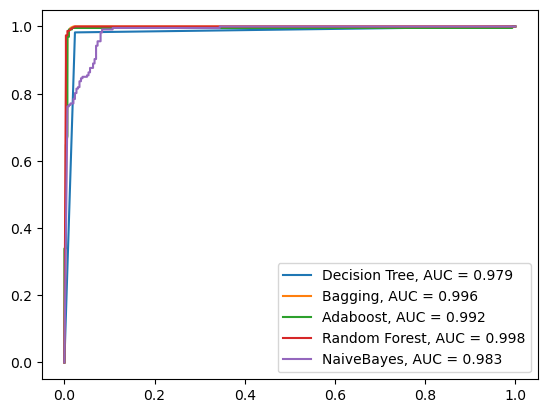

In [14]:
plt.figure(0).clf()

classifiers = {
    "Decision Tree": dTree,
    # "XGBoost": xgbClassifier,
    "Bagging": bagging,
    "Adaboost": adaboost,
    "Random Forest": random_forest,
    "NaiveBayes": naive_bayes
}

for name, classifier in classifiers.items():
    y_pred_probs = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    auc = roc_auc_score(y_test, y_pred_probs)
    plt.plot(fpr, tpr, label = f"{name}, AUC = {auc:.3f}")


plt.legend()

In [12]:
# m2cgen

dart_model = []

# naive_bayes_dart = m2c.export_to_dart(naive_bayes)
# random_forest_dart = m2c.export_to_dart(random_forest)
# xgbClassifier_dart = m2c.export_to_dart(xgbClassifier)
# adaboost_dart = m2c.export_to_dart(adaboost)

# with open('random_forest.dart', 'w') as f:
#     code = m2c.export_to_dart(random_forest)
#     f.write(code)
# with open('xgboost.dart', 'w') as f:
#     code = m2c.export_to_dart(xgbClassifier)
#     f.write(code)
# with open('xgboost.py', 'w') as f:
#     code = m2c.export_to_python(xgbClassifier)
#     f.write(code)
# with open('decision_tree.dart', 'w') as f:
#     code = m2c.export_to_dart(dTree)
#     f.write(code)
# import pickle



# with open('xgboost.pkl', 'wb') as file:

#     pickle.dump(xgbClassifier, file )



joblib.dump(xgbClassifier, "xgboost_model.pkl")

['xgboost_model.pkl']

In [13]:
# joblib.dump(x_train.columns, 'column_order.txt')